In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.2 MB/s eta 0:00:00


## Importing Libraries

In [ ]:
# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras import regularizers as rg
from tensorflow import keras
from tensorflow.keras import layers

# Garbage Collection and Pickle Imports
import gc
import pickle as pkl

# Visualization Imports
import matplotlib.pyplot as plt

# Operating System and Numerical Computation Imports
import os
import numpy as np

# Scikit-learn Import
from sklearn.model_selection import train_test_split

# Time-related Import
import time

# Data Handling Imports
import pandas as pd

import Levenshtein as lev


## Loading Testing Data

In [ ]:
test_features_path = "/content/drive/MyDrive/TextAnalyticsProject/PreprocessedData/test_features.pkl"
test_labels_path = "/content/drive/MyDrive/TextAnalyticsProject/PreprocessedData/test_labels.pkl"

with open(test_features_path, 'rb') as pickle_file:
    test_features = pkl.load(pickle_file)

with open(test_labels_path, 'rb') as pickle_file:
    test_labels = pkl.load(pickle_file)

## Loading models

In [ ]:
# Load the model from the HDF5 file
dnn_model = keras.models.load_model("/content/drive/MyDrive/TextAnalyticsProject/models/DNN/dnn_model.h5")

# Load the model from the HDF5 file
rnn_model = keras.models.load_model("/content/drive/MyDrive/TextAnalyticsProject/models/RNN/rnn_model.h5")
# Load the model from the HDF5 file

cnn_rnn_model = keras.models.load_model("/content/drive/MyDrive/TextAnalyticsProject/models/CNN-RNN/cnn_rnn_model.h5")

## Phoneme Mappings

In [ ]:
map_phonemes_61_to_39 = {
            'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
            'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
            'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
            'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
            'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
            'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
            'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
            'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#'
        }

phonemes_list_61 = list(map_phonemes_61_to_39.keys())
phonemes_list_39 = list(set(map_phonemes_61_to_39.values()))

label_to_phoneme39 = {}
phoneme39_to_label = {}
for index,phoneme in enumerate(phonemes_list_39):
    label_to_phoneme39[phoneme] = index + 1
    phoneme39_to_label[index + 1] = phoneme

map_phonemes_39_to_61 = {}

for phoneme61,phoneme39 in map_phonemes_61_to_39.items():
    if not phoneme39 in map_phonemes_39_to_61:
        map_phonemes_39_to_61[phoneme39] = []
    map_phonemes_39_to_61[phoneme39].append(phoneme61)

# Helper Functions

In [ ]:
def preprocess_features(features, labels):
    return features, labels

In [ ]:
def compute_per(X, y, model, phoneme_mapping, if_dnn):
    if not if_dnn:
        X = X.reshape(X.shape[0], 1, X.shape[1])
    # Get the model predictions
    predictions = model.predict(X)

    # Convert one-hot encoded vectors to phoneme sequences
    reference_phonemes = [one_hot_to_phoneme(vec, phoneme_mapping) for vec in y]
    predicted_phonemes = [one_hot_to_phoneme(vec, phoneme_mapping) for vec in predictions]

    # Calculate PER
    per = calculate_per(" ".join(reference_phonemes), " ".join(predicted_phonemes))

    # Observe the operations like insertion, deletion, and substitution
    editops = lev.editops(predicted_phonemes, reference_phonemes)
    insertions = []
    deletions = []
    replaces = []

    for op, pred_token, label_token in editops:
        if op == "insert":
            insertions.append(label_token)
        elif op == "delete":
            deletions.append(pred_token)
        else:
            replaces.append((pred_token, label_token))

    total_labels = len(reference_phonemes)
    pr_acc = (total_labels - len(insertions) - len(deletions) - len(replaces))/total_labels
    return per, pr_acc

def one_hot_to_phoneme(one_hot_vector, phoneme_mapping):
    index = np.argmax(one_hot_vector)
    return phoneme_mapping.get(index-1, "")

def calculate_per(reference, hypothesis):
    distance = lev.distance(reference, hypothesis)
    per = distance / len(reference)
    return per * 100

In [ ]:
def plot_performances(title, metric, dnn, rnn, rnn_cnn, w2v2):
    # Define the model names and corresponding metrics values
    models = ['DNN', 'RNN', 'RNN-CNN', 'XLSR-Wav2Vec2-CTC']
    accuracies = [dnn, rnn, rnn_cnn, w2v2]

    # Create a bar plot
    bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'yellow'])

    # Add title and labels
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel(metric)

    # Add metrics values on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom') # va: vertical alignment


    # Show the plot
    plt.show()

# Get performance metrics

In [ ]:
batch_size = 128

In [ ]:
X_test = test_features
y_test = test_labels
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_test, y_test)
)

test_dataset = (
    test_dataset.map(preprocess_features, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [ ]:
# Evaluate the model
cnn_rnn_loss, cnn_rnn_accuracy = cnn_rnn_model.evaluate(test_dataset)


4059/4059 [==============================] - 26s 4ms/step - loss: 1.6501 - accuracy: 0.5115


In [ ]:
# Evaluate the model
rnn_loss, rnn_accuracy = rnn_model.evaluate(test_dataset)

4059/4059 [==============================] - 30s 7ms/step - loss: 1.3606 - accuracy: 0.5856


In [ ]:
# Evaluate the model
dnn_loss, dnn_accuracy = dnn_model.evaluate(test_features, test_labels)

16236/16236 [==============================] - 53s 3ms/step - loss: 1.3999 - accuracy: 0.5828


In [ ]:
# Compute PER on the test data
cnn_rnn_per, cnn_rnn_pr_accuracy = compute_per(test_features, test_labels, cnn_rnn_model, phoneme39_to_label, False)

print(f'Loss: {cnn_rnn_loss}, Generic-Accuracy: {cnn_rnn_accuracy}, PR-Accuracy: {cnn_rnn_pr_accuracy}, Phoneme Error Rate: {cnn_rnn_per}%')

16236/16236 [==============================] - 51s 3ms/step
Loss: 1.6500742435455322, Generic-Accuracy: 0.5115134119987488, PR-Accuracy: 0.5250353688465426, Phoneme Error Rate: 31.320692288321446%


In [ ]:
# Compute PER on the test data
rnn_per, rnn_pr_accuracy = compute_per(test_features, test_labels, rnn_model, phoneme39_to_label, False)

print(f'Loss: {rnn_loss}, Generic-Accuracy: {rnn_accuracy}, PR-Accuracy: {rnn_pr_accuracy}, Phoneme Error Rate: {rnn_per}%')

16236/16236 [==============================] - 80s 5ms/step
Loss: 1.3605653047561646, Generic-Accuracy: 0.5855926275253296, PR-Accuracy: 0.5980847889899428, Phoneme Error Rate: 26.77136670467075%


In [20]:
# Compute PER on the test data
dnn_per, dnn_pr_accuracy = compute_per(test_features, test_labels, dnn_model, phoneme39_to_label, True)

print(f'Loss: {dnn_loss}, Generic-Accuracy: {dnn_accuracy}, PR-Accuracy: {dnn_pr_accuracy}, Phoneme Error Rate: {dnn_per}%')

16236/16236 [==============================] - 28s 2ms/step
Loss: 1.399860143661499, Generic-Accuracy: 0.5827611684799194, PR-Accuracy: 0.5959135749001492, Phoneme Error Rate: 27.150239474647144%


In [21]:
# Computed separately
xls_wav2vec2_pr_accuracy = 0.9262261856505878
xls_wav2vec2_per = 0.0730116868863158 * 100

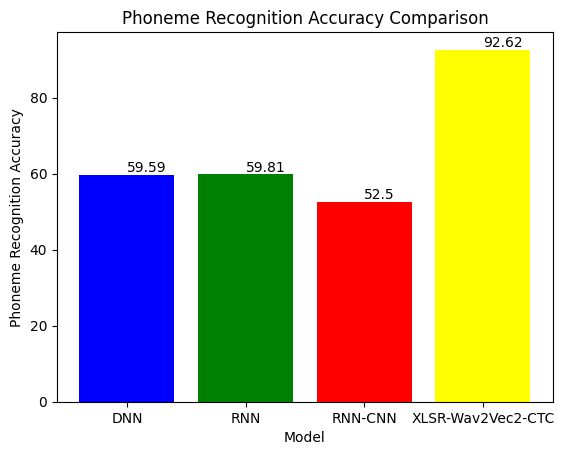

In [22]:
dnn_pr_accuracy, rnn_pr_accuracy, cnn_rnn_pr_accuracy, xls_wav2vec2_pr_accuracy = dnn_pr_accuracy*100, rnn_pr_accuracy*100, cnn_rnn_pr_accuracy*100, xls_wav2vec2_pr_accuracy*100
plot_performances("Phoneme Recognition Accuracy Comparison" , "Phoneme Recognition Accuracy", dnn_pr_accuracy, rnn_pr_accuracy, cnn_rnn_pr_accuracy, xls_wav2vec2_pr_accuracy)

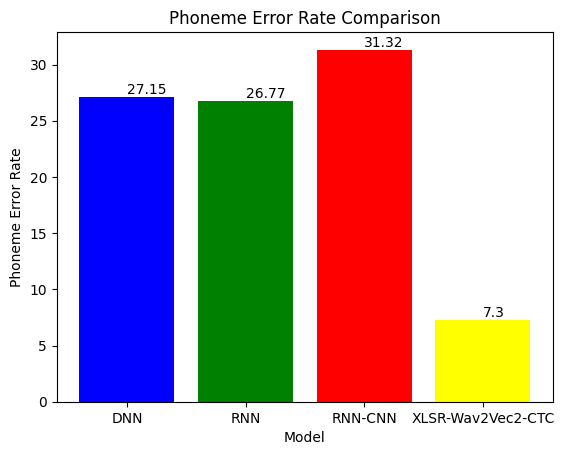

In [23]:
plot_performances("Phoneme Error Rate Comparison" , "Phoneme Error Rate", dnn_per, rnn_per, cnn_rnn_per, xls_wav2vec2_per)